This notebook implements a very simple sequential network with pytorch. The dataset used is very small, and only used for some preliminary trials. The dataset is composed of three T1 images (class 0) and three FA images (class 1). The aim of this simple network is to classify images into the two classes. The training is done using a GPU and, in this example, only the central 10 axial slices are used. A deeper network is used here, and the new classes CropBorders3D() and SelectAxialSlices3D() are used.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch
import torchvision.transforms as transforms
from torch.utils.data import random_split
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
import pandas as pd

torch.set_printoptions(edgeitems=2)
torch.manual_seed(0)

In [2]:
#mount the drive folder
from google.colab import drive
drive.mount('/content/drive') 
%cd /content/drive/My\ Drive/work/my_tests

Mounted at /content/drive
/content/drive/My Drive/work/my_tests


In [3]:
#load the dataset as an instance of the class customDataset
from customDataset import HCPanatDataset, CropBorders3D, SelectAxialSlices3D, training_loop_val, validate
img_dir = 'HCP-anat-data/images/'
dataset = HCPanatDataset(csv_file='HCP-anat-data/annotations.csv', root_dir=img_dir)

Training on device cuda.


In [4]:
#apply some transformation to the data (crop)
transformed_dataset = HCPanatDataset(
    csv_file='HCP-anat-data/annotations.csv', 
    root_dir=img_dir, 
    transform=transforms.Compose([
        CropBorders3D(20)]))

In [5]:
#check dimensions
t1, _ = transformed_dataset[0]
print(t1.shape)

(105, 134, 105)


In [6]:
#apply some transformation to the data (crop and select axial slices)
transformed_dataset = HCPanatDataset(
    csv_file='HCP-anat-data/annotations.csv', 
    root_dir=img_dir, 
    transform=transforms.Compose([
        CropBorders3D(20),
        SelectAxialSlices3D(10)]))

In [7]:
#check dimensions
t1, _ = transformed_dataset[0]
print(t1.shape)

(105, 134, 10)


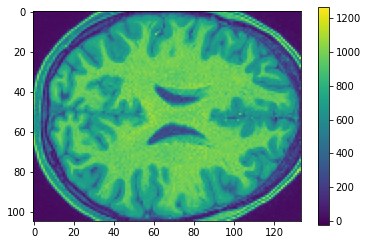

In [8]:
#visualize an example of T1 cropped
m=np.int(t1.shape[2]/2)
im=plt.imshow(t1[:,:,m])
plt.colorbar(im)

In [9]:
#compute the mean and std of the data
max_dim = len(t1.shape) #concatenating dimension
imgs = np.stack([img for img, _ in transformed_dataset], axis=max_dim)
mean = np.mean(imgs)
std = np.std(imgs)
mean, std

(334.1098, 395.95114)

In [10]:
#normalize the data
normalized_dataset = HCPanatDataset(
    csv_file='HCP-anat-data/annotations.csv', 
    root_dir=img_dir, 
    transform=transforms.Compose([
        CropBorders3D(20),
        SelectAxialSlices3D(10),
        transforms.ToTensor(),
        transforms.Normalize(mean,std)]))

In [11]:
#split the dataset into training and test sets with torch.utils.data.random_split
N = len(normalized_dataset)
perc_train = 0.8
train_set, test_set = random_split(normalized_dataset, [int(perc_train*N), N-int(perc_train*N)]) 
print("Total number of images: %i" %N)
print("Number of training images: %i" %(perc_train*N))
print("Number of test images: %i" %(N-int(perc_train*N)))

Total number of images: 6
Number of training images: 4
Number of test images: 2


In [12]:
#define hyperparameters
n_in = imgs.shape[0] * imgs.shape[1] * imgs.shape[2] #number of input features
labels = pd.read_csv('HCP-anat-data/annotations.csv')['label']
n_out = len(np.unique(labels)) #number of output features, i.e. number of classes
n_epochs = 20
batch_size = 1
print("The number of input feature is: %i" %n_in)
print("The number of output feature is: %i" %n_out)

The number of input feature is: 140700
The number of output feature is: 2


In [13]:
#assuming that we are on a CUDA machine, this should print a CUDA device:
device = (torch.device('cuda') if torch.cuda.is_available() 
          else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [14]:
#increase (even more) the number of layers and change the loss to CrossEntropy
seq_model_large = nn.Sequential(
            nn.Linear(n_in, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, n_out))
seq_model_large = seq_model_large.to(device=device)
optimizer = optim.SGD(seq_model_large.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

In [15]:
#split the datasets into batches
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)

In [16]:
#training and showing also validation loss
import time
t0 = time.time()
loss_vector, loss_val_vector = training_loop_val(
    model = seq_model_large,
    train_loader = train_loader,
    test_loader = test_loader,
    criterion = loss_fn,
    optimizer = optimizer,
    n_epochs = n_epochs)
print("Training time = %f seconds" %(time.time()-t0))

Epoch: 0, Training Loss: 0.129475, Validation Loss: 0.153084
Epoch: 1, Training Loss: 0.136851, Validation Loss: 0.094821
Epoch: 2, Training Loss: 0.085222, Validation Loss: 0.120288
Epoch: 3, Training Loss: 0.114939, Validation Loss: 0.080851
Epoch: 4, Training Loss: 0.077423, Validation Loss: 0.107063
Epoch: 5, Training Loss: 0.072224, Validation Loss: 0.073659
Epoch: 6, Training Loss: 0.100013, Validation Loss: 0.098852
Epoch: 7, Training Loss: 0.096659, Validation Loss: 0.068769
Epoch: 8, Training Loss: 0.065497, Validation Loss: 0.092862
Epoch: 9, Training Loss: 0.063775, Validation Loss: 0.090366
Epoch: 10, Training Loss: 0.088824, Validation Loss: 0.063429
Epoch: 11, Training Loss: 0.060788, Validation Loss: 0.086046
Epoch: 12, Training Loss: 0.060201, Validation Loss: 0.084142
Epoch: 13, Training Loss: 0.082934, Validation Loss: 0.082373
Epoch: 14, Training Loss: 0.081241, Validation Loss: 0.080719
Epoch: 15, Training Loss: 0.056626, Validation Loss: 0.079165
Epoch: 16, Trainin

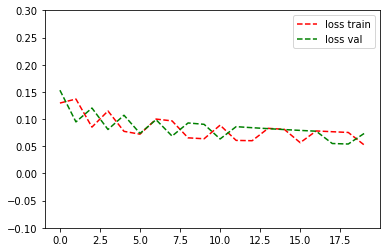

In [17]:
#plot training and validation loss
x_axis = np.arange(n_epochs)
plt.plot(x_axis, loss_vector, 'r--', label='loss train')
plt.plot(x_axis, loss_val_vector, 'g--', label='loss val')
plt.ylim(-0.1, 0.3)
plt.legend()

In [18]:
#compute accuracy in training and validation
validate(seq_model_large, train_loader, test_loader)

Accuracy train: 1.00
Accuracy validation: 1.00


In [19]:
numel_list = [p.numel()
              for p in seq_model_large.parameters()
              if p.requires_grad == True]
sum(numel_list), numel_list              

(72112962, [72038400, 512, 65536, 128, 8192, 64, 128, 2])

w.r.t. the previous example that uses the entire 3D volumes, here we have 72M parameters instead of 468M parameters, even though we used a network with one more hidden layer (Linear+Tanh)!